In [0]:
##Author : Vipin Das
##Master's in Computer Science with Big Data 
##Simon Fraser University, Burnaby
##Created on : April 10, 2020

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev, stddev_pop, avg, max, to_timestamp, udf, desc, min
from pyspark.ml.feature import VectorAssembler, SQLTransformer, StandardScaler
from pyspark.ml.clustering import KMeansModel
import pandas as pd

from pyspark.sql import Window

spark = SparkSession.builder.appName('Kmeans-Lift1').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('Z', types.DoubleType()),
        types.StructField('Anomaly', types.IntegerType())
    ])
    return sen_schema
def calc_score(count, min_max_collection):
    min_count = float(min_max_collection[0])
    max_count = float(min_max_collection[1])
    score = (max_count - count) / (max_count - min_count)
    return score
def calc_anom(score):
    if score > 0.9999:
        value = 1
    else:
        value = 0
    return value
sens_schema = sensor_schema()
# Spark read of data
temp = spark.read.csv('/content/drive/My Drive/nor_window_data.csv', schema=sens_schema)

In [0]:
temp = temp.filter(temp['timestamp'].isNotNull())

In [0]:
unlist = udf(lambda x: round(float(list(x)[0]), 6), types.DoubleType())

In [0]:
assembler = VectorAssembler(
        inputCols=["Z"],
        outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale", withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()

In [0]:
scaledData = scaledData.withColumn("times", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
movAvg = scaledData.withColumn("movingAverage", avg(scaledData["Zscale"])
                                   .over(Window.partitionBy(scaledData["times"]).rowsBetween(-3, 3))).cache()
movAvg.createOrReplaceTempView("movAvg")
scaledNorm = spark.sql("select timestamp,times,Z,Zscale,round(movingAverage,0) as Zround from movAvg").cache()

In [0]:
cols = ["Zscale", "Zround"]
ft_assembler = VectorAssembler(inputCols=cols, outputCol="features")
in_df = ft_assembler.transform(scaledNorm)

In [0]:
# load the model
model = KMeansModel.load('/content/drive/My Drive/Model')

# use the model to make predictions
predict = model.transform(in_df)

# Calculate the total count of each cluster
count_df = predict.groupBy("prediction").count().cache()

In [0]:
predict.show()

+---------+-----+--------+---------+------+---------------+----------+
|timestamp|times|       Z|   Zscale|Zround|       features|prediction|
+---------+-----+--------+---------+------+---------------+----------+
|  35:27.0| null|0.789063| 0.065031|   0.0| [0.065031,0.0]|         4|
|  35:27.0| null|0.785156|-0.161642|   0.0|[-0.161642,0.0]|         5|
|  35:27.1| null| 0.78125|-0.388257|   0.0|[-0.388257,0.0]|         5|
|  35:27.1| null|0.785156|-0.161642|   0.0|[-0.161642,0.0]|         5|
|  35:27.1| null|0.789063| 0.065031|   0.0| [0.065031,0.0]|         4|
|  35:27.2| null| 0.78125|-0.388257|   0.0|[-0.388257,0.0]|         5|
|  35:27.2| null|0.789063| 0.065031|   0.0| [0.065031,0.0]|         4|
|  35:27.3| null|0.785156|-0.161642|   0.0|[-0.161642,0.0]|         5|
|  35:27.3| null|0.785156|-0.161642|   0.0|[-0.161642,0.0]|         5|
|  35:27.3| null| 0.78125|-0.388257|   0.0|[-0.388257,0.0]|         5|
|  35:27.4| null| 0.78125|-0.388257|   0.0|[-0.388257,0.0]|         5|
|  35:

In [0]:
min_max_list = count_df.agg(min('count'), max('count')).collect()[0]

    # Calculating the scores
udf_calc_score = udf(lambda count: calc_score(float(count), min_max_list), types.FloatType())
anom_score = count_df.withColumn("score", udf_calc_score("count")).cache()


In [0]:
anom_score.show()

+----------+-----+----------+
|prediction|count|     score|
+----------+-----+----------+
|         1|   30|0.97850823|
|         5|  804|       0.0|
|         4|  586| 0.2756005|
|         7|   58|   0.94311|
|        10|   13|       1.0|
|         2|   13|       1.0|
|         0|   16|0.99620736|
+----------+-----+----------+



In [0]:

    # Populating scores. If you need additional columns enable this code
predict = predict.join(anom_score, "prediction").select("timestamp", "Z", "score")
    # Anomaly detection based om threshold
udf_anom = udf(lambda score: calc_anom(score), types.IntegerType())
anomaly = predict.withColumn("anomaly", udf_anom("score"))
anomaly1 = predict.where(predict["score"] > 0.9999)

    #Convert to csv
pd_anom = anomaly.toPandas()
pd_anom.to_csv('Kmeans_Lift1_preds.csv',index=False)

In [0]:
pd_anom

,timestamp,Z,score,anomaly
0,35:27.0,0.789063,0.275600,0
1,35:27.0,0.785156,0.000000,0
2,35:27.1,0.781250,0.000000,0
3,35:27.1,0.785156,0.000000,0
4,35:27.1,0.789063,0.275600,0
...,...,...,...,...
1515,36:26.8,0.781250,0.000000,0
1516,36:26.8,0.804688,0.275600,0
1517,36:26.8,0.777344,0.000000,0
1518,36:26.9,0.773438,0.996207,0


In [0]:
# Use the file generated for evaluation
reference = pd.read_csv('/content/drive/My Drive/nor_window_data.csv',header=None)

In [0]:

reference.rename(columns={ reference.columns[0]: 'Pos',reference.columns[1]: 'Value',reference.columns[2]: 'Anomaly'}, inplace=True)

No handles with labels found to put in legend.


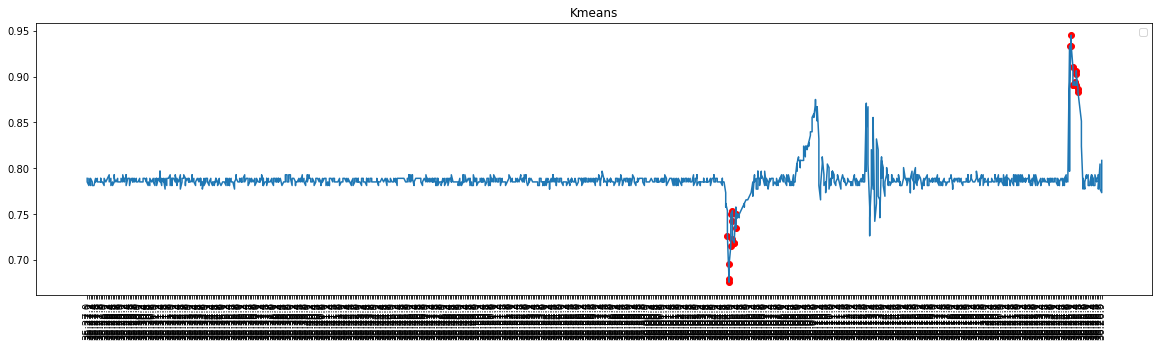

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
pd_anom.sort_values(by=['timestamp'],inplace=True)
plt.plot(pd_anom['timestamp'],pd_anom['Z'],'-')
plt.scatter(pd_anom.timestamp[pd_anom.anomaly==True], pd_anom.Z[pd_anom.anomaly==True],marker='o',c='red')
plt.title('Kmeans')
plt.xticks(rotation = 90)
plt.legend();

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
y_true = reference['Anomaly']    # the true anomaly column(0/1)
y_pred = pd_anom['anomaly']    # the predicted anomaly column

In [0]:
# Find the confusion matrix
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()

In [0]:
print("True negatives :",tn)
print("False positives :",fp)
print("True positives :",fn)
print("False negatives :",tp)

True negatives : 1456
False positives : 15
True positives : 38
False negatives : 11


In [0]:
# Calculate precision and recall

precision = tp/(tp + fp)
recall = tp/(tp + fn) 

In [0]:
precision

0.4230769230769231

In [0]:
recall

0.22448979591836735

In [0]:
f1_score = (2*(precision * recall))/(precision + recall)

In [0]:
f1_score

0.29333333333333333